# Image regression

A typical deep learning problem is image classification (see earlier notebooks), but sometimes we want to perform a regression problem where our output is in $\mathbb{R}^D$. We can easily tweak classification models to perform regression as we'll show in this example.

In this notebook, we'll try to train a CNN to find the centre of someone's head.

In [1]:
from fastai.vision import *

Download the data

In [2]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [3]:
path

PosixPath('/home/jupyter/.fastai/data/biwi_head_pose')

In [5]:
path.ls()[:5]

[PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/05.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/02.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/12'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/01.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/03')]

In [7]:
(path/'01').ls()[:5]

[PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/01/frame_00469_pose.txt'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/01/frame_00466_pose.txt'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/01/frame_00402_pose.txt'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/01/frame_00049_pose.txt'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/01/frame_00056_rgb.jpg')]

From the dataset readme, each folder contains two `.cal` files containing calibration information for the depth and the color camera.

In [10]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [11]:
fname = '09/frame_00667_rgb.jpg'

In [12]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

In [16]:
img2txt_name(fname)

PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/09/frame_00667_pose.txt')

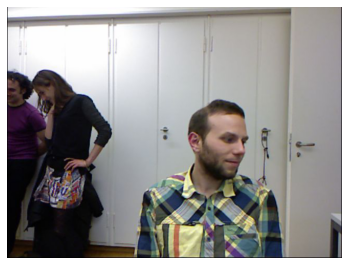

In [27]:
img = open_image(path/fname)
img.show(figsize=(6,6))

In [28]:
img.shape

torch.Size([3, 480, 640])

In [17]:
centre = np.genfromtxt(img2txt_name(fname), skip_header=3); centre

array([187.332 ,  40.3892, 893.135 ])

Define some methods to convert 3D coordinates provided into the corresponding 2D space of the images, as per the dataset documentation (and a bit of help from Jeremy)

In [19]:
doc(ImagePoints)

We'll be using `ImagePoints` for our data bunch

In [35]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_centre(fname):
    centre = np.genfromtxt(img2txt_name(fname), skip_header=3)
    return convert_biwi(centre)

def get_image_points(img, pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [36]:
centre = get_centre(fname); centre

tensor([263.9104, 428.5814])

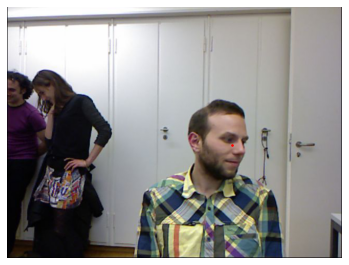

In [37]:
img.show(y=get_image_points(img, centre), figsize=(6,6))

So the data are a picture, with a coordinate of the centre of the main subject's head.

## Create dataset

We'll use a person that the model has never seen for validation -- person 13.

In [38]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_centre)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

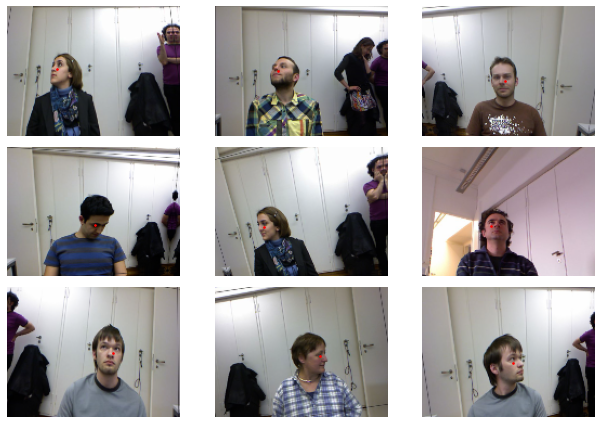

In [39]:
data.show_batch(3, figsize=(9,6))

## Train model

In [40]:
learn = cnn_learner(data, models.resnet34)

epoch,train_loss,valid_loss,time


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


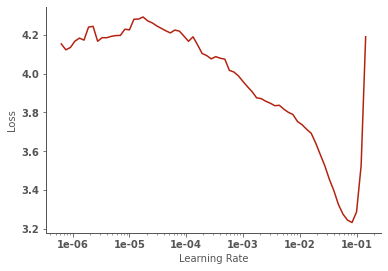

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
lr = 2e-2

In [43]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,0.125900,0.013193,00:43
1,0.042123,0.004738,00:43
2,0.014621,0.001981,00:43
3,0.008736,0.004647,00:43
4,0.006694,0.004002,00:43


In [44]:
learn.save('stage-1')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


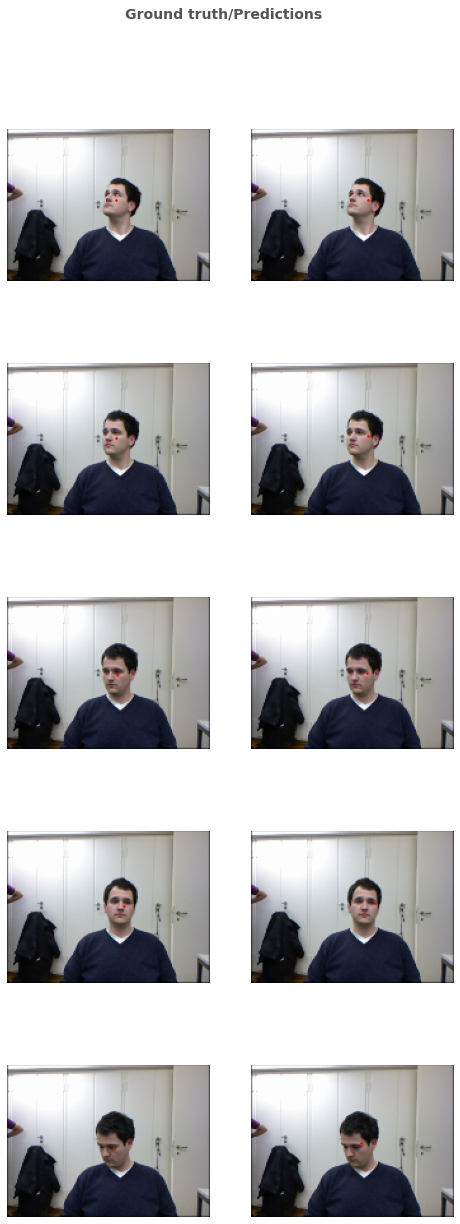

In [45]:
learn.show_results()

Easy-peasy